# Suggest an option strategy

We want to buy/sell an option in the SPY market. 
A good stratey would be one where
 - Expiration date is some 40 days from now
 - Probaility of profit and expected returns are high

To determine our options:
 1. Load current option chain for SPY
 2. expDate = next expiration date 40 days from now
 3. Compute Probability of Profit (POP)
     - Simulate SPY price evolution untill expDate (Monte Carlo)
     - Assess strategy: how often have you made a profit?
     - Check: if you plot Bid vs POP you should see a negative correlation
 4. Select best options based on POP and Bid price

Assuming:
 - European-type options
 - strategy: only naked call/put
 - we are buying the option (i.e. using 'Bid' and not 'Ask')
 
To add:
 - expected return = \int{expir_price_distribution()}/(expir_price_range)

In [1]:
import math
import pandas
import numpy 
import datetime
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline
#from ggplot import *


def side_by_side(*objs, **kwds):
    from pandas.core.common import adjoin
    space = kwds.get('space', 4)
    reprs = [repr(obj).split('\n') for obj in objs]
    print (adjoin(space, *reprs))
    

trading_days_in_a_year = 252

## Retrieve option prices from Yahoo Finance

In [2]:
from pandas.io.data import Options

filename = str(datetime.date.today()) + '_SPY_optionChain.csv'
try:
    spy_data = pandas.read_csv(filename)
    spy_data = spy_data.set_index('Symbol')
    spy_data.head()
except OSError:
    print (" --> Today's option chain not on system: \
    downloading it now... ")
    spy_options = Options('SPY', 'yahoo')
    spy_data = spy_options.get_all_data()
    spy_data = spy_data.reset_index()
    spy_data = spy_data.set_index('Symbol')
    spy_data.to_csv(filename, date_format='%Y-%m-%d')



In [3]:
spy_data[0:3]   ## access the first 3 rows in the data

,Strike,Expiry,Type,Last,Bid,Ask,Chg,PctChg,Vol,Open_Int,IV,Root,IsNonstandard,Underlying,Underlying_Price,Quote_Time
Symbol,,,,,,,,,,,,,,,,
SPY171215C00010000,10,2017-12-15,call,197.50,179.50,184.40,0,0.00%,1,1,89.65%,SPY,False,SPY,191.92,2016-01-10
SPY171215P00010000,10,2017-12-15,put,0.03,0.02,0.04,0,0.00%,285,33082,75.78%,SPY,False,SPY,191.92,2016-01-10
SPY161216C00015000,15,2016-12-16,call,191.00,174.60,179.40,0,0.00%,390,0,114.26%,SPY,False,SPY,191.92,2016-01-10


## Find an interesting expiry date

In [4]:
import datetime

def next_available_expiration_date(how_many_days_from_now = 40, 
                                   underlyingDataFrame = spy_data):
    '''
    Looks up the given pandas.io.data.Options object and returns 
    the next expiration date (string)
    '''
    # get all unique values in 'Expiry'
    expDates_str = pandas.Series(spy_data.Expiry.ravel()).unique()
    # convert values to date obj
    expDates = [ datetime.datetime.strptime(exp_str, '%Y-%m-%d').date()
                for exp_str in expDates_str ] 
    
    expDates.sort()
    for date in expDates:
        if date > date.today() + datetime.timedelta(how_many_days_from_now):
            expiry = date
            break
    return (expiry)

Example

In [5]:
expDate = next_available_expiration_date(how_many_days_from_now=40, underlyingDataFrame=spy_data)
expDate

datetime.date(2016, 2, 26)

## Compute probability of Profit

#### MonteCarlo simulation
https://en.wikipedia.org/wiki/Monte_Carlo_methods_in_finance#Monte_Carlo_methods

To sample a path following the Black-Scholes model from time 0 to T, we chop the time interval into M units of length $\delta t$, and approximate the Brownian motion over the interval dt by a single normal variable of mean 0 and variance $\delta t$. This leads to a sample path of

$$
S( k\delta t) = S(0) \exp\left( \sum_{i=1}^{k} \left[\left(\mu - \frac{\sigma^2}{2}\right)\delta t + \sigma\varepsilon_i\sqrt{\delta t}\right] \right)
$$

for each k between 1 and M. Here each $\varepsilon_i$ is a draw from a standard normal distribution

In [6]:
def evolve_underlying_price(underlying_price = 200, 
                            averageUnderlyingReturns = .0907,
                            volatility = .2, days_to_expiration = 7, 
                            nTrials = 1000):
    '''
    Monte Carlo simulation of stock price evolution.
    Assuming a lognormal distribution of prices, computes 
    price paths and returns a DataFrame(days_to_expir X nTrials):
    each column is the day-by-day evolution of the stock price
    '''
    t = 1/252
    moves = []
    mu = (averageUnderlyingReturns - pow(volatility,2)/2)
    for trial in range(nTrials):
        randArray = numpy.random.normal(0, 1, days_to_expiration-1)
        prices = [underlying_price]
        for eps in randArray:
            change = math.exp(mu*t + volatility*eps*pow(t,0.5))
            prices.append(numpy.round(prices[-1]*change, decimals=2))
        moves.append(prices)

    df = pandas.DataFrame(moves)
    df = df.transpose()
    return df


Example:
 - Find how many days to expiration
 - evolve SPY price
 - plot the simulated paths

In [8]:
from pylab import gca, draw
next_expir = next_available_expiration_date(how_many_days_from_now=40, 
                                            underlyingDataFrame=spy_data)
days_to_exp = next_expir - datetime.date.today()
underlSimulPaths = evolve_underlying_price(days_to_expiration=days_to_exp.days, 
                                           nTrials=500)


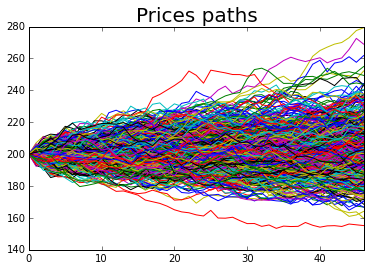

In [9]:
underlSimulPaths.plot()
plt.title('Prices paths', fontsize=20)
ax = gca()
ax.legend_ = None
draw()

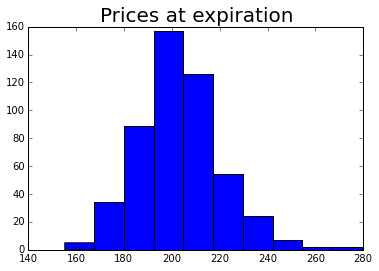

In [10]:
# Prices at the last day
plt.hist(underlSimulPaths.iloc[-1])
plt.title('Prices at expiration', fontsize=20)

#### Compute profit/loss at expiration

In [12]:
def profit_at_expiration_for_single_option(underlyingPriceAtExpiration=100, 
                                           strike=90, optionType='call', 
                                           Price=2):
    underlyingPrice = underlyingPriceAtExpiration
    '''
    Compute the returns from a naked call/put option at expiration given: 
     - the debit/credit payed/gained for it (i.e. 'Price')
     - the underlying price at expiration
     
    Use parameter 'Price' to differenciate between having bought (Price>0) 
    or sold (Price<0)the option.
    '''
    if Price == 0:
        print(' --> profit_at_expiration_for_single_option(): \
        can not work with a Bid price == 0 $')
    optionBought = (Price>0)
    Price = math.fabs(Price)
    if optionType == 'call':
        if underlyingPrice > strike and optionBought: 
            output = underlyingPrice - strike
        elif underlyingPrice <= strike and optionBought:
            output = 0 # option expires worthless
        elif underlyingPrice > strike and not optionBought:
            output = Price -1* (underlyingPrice - strike)
        elif underlyingPrice <= strike and not optionBought:
            output = Price # you get to keep the premium
    elif optionType == 'put':
        if underlyingPrice < strike and optionBought: 
            output = strike - underlyingPrice
        elif underlyingPrice >= strike and optionBought:
            output = 0 # option expires worthless
        elif underlyingPrice < strike and not optionBought:
            output = Price -1* (strike - underlyingPrice)
        elif underlyingPrice >= strike and not optionBought:
            output = Price  # you get to keep the premium
    else:
        print(' --> profit_at_expiration_for_single_option(): \
        do not recognize option type')
        output = None
    return output

In [17]:
def strategy_assessment(strike, optionType, price, underlPathsDataFrame, 
                        getOutcomes=False):
    '''    
    Compute the returns from a naked call/put option at expiration given: 
     - the debit/credit payed/gained for it (i.e. 'Price')
     - a simulated paths evolution of its underlying. 
    for each path in the simulation
    
    Returns [POP, list_of_returns]
    '''
    outcome = []
    count = 0
    nTrials = len(underlPathsDataFrame) # i.e. num of simulated paths
    for trial in range(nTrials):
        #(underlyingPriceAtExpiration=100, strike=90, optionType='call', Price=2):
        out = profit_at_expiration_for_single_option(underlPathsDataFrame[trial].iloc[-1],
                                                     strike, optionType, price)
        if getOutcomes:
            outcome.append(out)
        if out > 0:
            count += 1
    #print('Prob. of Profit: ', count / len(df.keys()))
    if getOutcomes:
        return [count / nTrials, outcome]
    else:
        return(count / nTrials)

Example

Probability of Profit: 46.81 %


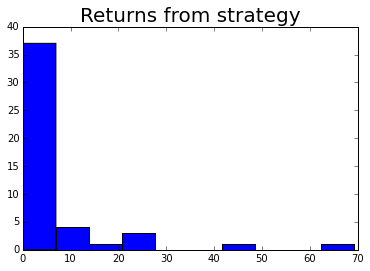

In [46]:
res = strategy_assessment(strike=210, optionType='call', price=.01, 
                          underlPathsDataFrame=underlSimulPaths, 
                          getOutcomes=True)  

# 'Probability of Profit: %s' % 
print('Probability of Profit: %.2f %%' % (res[0]*100))
plt.hist(res[1])
plt.title('Returns from strategy', fontsize=20)

### Compute POP for all (interesting) entries in the option chain

In [47]:
expiry = next_available_expiration_date(40, spy_data)
www = spy_data[(spy_data['Expiry']==str(expiry)) & (spy_data['Bid']>0)]
www = www[['Strike', 'Type', 'Bid', 'Ask', 'IV']]

pops = pandas.DataFrame()

popBuy = www.reset_index()
for i in range(len(popBuy)):
    sym, s, t, b, a, iv = popBuy.loc[i]
    pop = strategy_assessment(s,t,b, underlSimulPaths, False)
    pops = pops.append(pandas.Series([sym, s, t, pop, b]), ignore_index=True)

pops.columns = ['Symbol','Strike','type', 'pop', 'Bid']
pops.head()

,Symbol,Strike,type,pop,Bid
0,SPY160226C00190000,190,call,0.851064,7.11
1,SPY160226P00190000,190,put,0.148936,5.39
2,SPY160226P00191000,191,put,0.170213,5.77
3,SPY160226P00192000,192,put,0.191489,6.17
4,SPY160226C00193000,193,call,0.808511,5.32


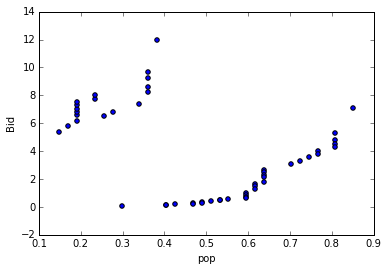

In [48]:
pops.plot(kind='scatter', x='pop', y='Bid')

In [49]:
pops[pops['pop']>.08]

,Symbol,Strike,type,pop,Bid
0,SPY160226C00190000,190.0,call,0.851064,7.11
1,SPY160226P00190000,190.0,put,0.148936,5.39
2,SPY160226P00191000,191.0,put,0.170213,5.77
3,SPY160226P00192000,192.0,put,0.191489,6.17
4,SPY160226C00193000,193.0,call,0.808511,5.32
5,SPY160226P00193000,193.0,put,0.191489,6.62
6,SPY160226P00193500,193.5,put,0.191489,6.81
7,SPY160226C00194000,194.0,call,0.808511,4.78
8,SPY160226P00194000,194.0,put,0.191489,7.04
9,SPY160226C00194500,194.5,call,0.808511,4.51


ToDo:
get pops back in the main dataframe, keeping track of matching the call/put